# Other

In [ ]:
# make optimised sort and slice feature extractor function, print info function, break ties with lambda function
# check whether optimised sort and slice feature extractor leads to similar results as in my experiments


# check whether hashed method has not changed by implementing counts

# copy paper results in again


# design readme file and embedd figures
# link to the paper in readme file
# give instructions/code/functions on how to easily use sort and slice in other projects




# ideas:
# research project: extract features from target space to see if it improves out-of-distribution-generalisation
# generate ecfps that are calibrated to entire chemical space (paper of all molecules)

In [ ]:
import numpy as np
from rdkit.Chem import rdFingerprintGenerator



def construct_sort_and_slice_ecfp_featuriser(mols_train, 
                                             max_radius = 2, 
                                             pharm_atom_invs = False, 
                                             bond_invs = True, 
                                             chirality = False, 
                                             sub_counts = True, 
                                             vec_dimension = 1024, 
                                             break_ties_with = lambda sub_id: sub_id, 
                                             print_train_set_info = True):
    """
    Creates a function "ecfp_featuriser" that maps RDKit mol objects to vectorial ECFP fingerprints pooled via Sort & Slice (instead of traditional hash-based folding for substructure pooling).
    See also "Sort & Slice: A Simple and Superior Alternative to Hash-Based Folding for Extended-Connectivity Fingerprints" by Dablander, Hanser, Lambiotte and Morris (2024): https://arxiv.org/abs/2403.17954.
    
    
    INPUTS:
    
    - mols_train (list)            ...  A list of RDKit mol objects [mol_1, mol_2, ...] that are used as the training set to calibrate the Sort & Slice substructure pooling operator.
    
    - max_radius (int)             ...  The maximal radius up to which to generate the integer ECFP-substructure identifiers. Common choices are 1, 2 or 3 (corresponding to maximal diameters of 2, 4, or 6).
    
    - pharm_atom_invs (bool)       ...  If False, then the standard initial atomic invariants from RDKit (including ring membership) are used to generate the ECFPs. 
                                        If True, then instead binary pharmacophoric initial atomic invariants are used to generate what is referred to as FCFPs.
    
    - bond_invs (bool)             ...  Whether or not to take into account bond invariants when generating the integer ECFP-substructure identifiers (default = True).
    
    - chirality (bool)             ...  Whether or not to take into account chirality when generating the integer ECFP-substructure identifiers (default = False).
    
    - sub_counts (bool)            ...  Whether ecfp_featuriser should generate binary vectorial fingerprints (sub_counts = False) that indicate the mere presence or absence of substructures; 
                                        or integer fingerprints (sub_counts = True) that additionally indicate how many times a substructure is found in the input compound.
    
    - vec_dimension (int)          ...  Length of the vectorial Sort & Slice ECFP. Common choices are 512, 1024, 2048 and 4096. 
                                        Only the vec_dimension most prevalent ECFP-substructures in mols_train are included in the final vector representation.
    
    - break_ties_with (function)   ...  Function to map the integer ECFP-substructure identifiers to values that are used to break ties when sorting the substructure identifiers according to their prevalence in mols_train. 
                                        The default is the identity map (i.e., lambda sub_id: sub_id) which breaks ties using the (arbitrary) ordering defined by the integer substructure identifier themselves.
                                        If break_ties_with = None, then ties are broken automatically as part of the application of Python's sorted() command to sub_ids_to_prevs_dict.
    
    - print_train_set_info (bool)  ...  Whether or not to print out the number of compounds and the number of unique integer ECFP-substructure identifiers 
                                        (i.e., the number of unique circular substructures) with the specified parameters in mols_train.
    
    
    OUTPUT:
    
    - ecfp_featuriser (function)   ...    A function that maps RDKit mol objects to vectorial ECFP fingerprints (1-dimensional numpy arrays of length vec_dimension) via a Sort & Slice substructure pooling operator trained on mols_train.
    
    
    EXAMPLE:
    
    First construct a molecular featurisation function with desired settings, for instance via
    
    ecfp_featuriser = construct_sort_and_slice_ecfp_featuriser(mols_train = [mol_1, mol_2, ...], 
                                                               max_radius = 2, 
                                                               pharm_atom_invs = False, 
                                                               bond_invs = True, 
                                                               chirality = False, 
                                                               sub_counts = True, 
                                                               vec_dimension = 1024, 
                                                               break_ties_with = lambda sub_id: sub_id, 
                                                               print_train_set_info = True)
                                                               
    Note that the ECFP settings (max_radius, pharm_atom_invs, bond_invs, chirality, sub_counts, vec_dimension, break_ties_with) and chemical information from mols_train are all by construction implicitly transferred to "ecfp_featuriser".
    
    Now let mol be an RDKit mol object. Then ecfp_featuriser(mol) is a 1-dimensional numpy array of length vec_dimension representing the vectorial Sort & Slice ECFP fingerprint for mol.
    
    The fingerprint ecfp_featuriser(mol) is generated by (i) first generating the (multi)set of integer ECFP-substructure identifiers for mol and then (ii) vectorising it via the Sort & Slice operator trained on mols_train (rather than vectorising it via classical hash-based folding).
    """
    
    # create substructure enumerator function that maps a mol object to a dictionary whose keys are all the integer substructure identifiers identified in mol and whose values are the associated substructure counts in mol (i.e., how often each substructure appears in mol)
    morgan_generator = rdFingerprintGenerator.GetMorganGenerator(radius = max_radius,
                                                                 atomInvariantsGenerator = rdFingerprintGenerator.GetMorganFeatureAtomInvGen() if pharm_atom_invs == True else rdFingerprintGenerator.GetMorganAtomInvGen(includeRingMembership = True),
                                                                 useBondTypes = bond_invs,
                                                                 includeChirality = chirality)
    
    sub_id_enumerator = lambda mol: morgan_generator.GetSparseCountFingerprint(mol).GetNonzeroElements()
    
    # construct dictionary that maps each integer substructure identifier sub_id in mols_train to its associated prevalence (i.e., to the total number of compounds in mols_train that contain sub_id at least once)
    sub_ids_to_prevs_dict = {}
    for mol in mols_train:
        for sub_id in sub_id_enumerator(mol).keys():
            sub_ids_to_prevs_dict[sub_id] = sub_ids_to_prevs_dict.get(sub_id, 0) + 1

    # create list of integer substructure identifiers sorted by prevalence in mols_train
    sub_ids_sorted_list = sorted(sub_ids_to_prevs_dict, key = lambda sub_id: (sub_ids_to_prevs_dict[sub_id], break_ties_with(sub_id)), reverse = True)
    
    # create auxiliary function that generates standard unit vectors in numpy
    def standard_unit_vector(dim, k):
        
        vec = np.zeros(dim, dtype = int)
        vec[k] = 1
        
        return vec
    
    # create one-hot encoder for the first vec_dimension substructure identifiers in sub_ids_sorted_list; all other substructure identifiers are mapped to a vector of 0s
    def sub_id_one_hot_encoder(sub_id):
        
        return standard_unit_vector(vec_dimension, sub_ids_sorted_list.index(sub_id)) if sub_id in sub_ids_sorted_list[0: vec_dimension] else np.zeros(vec_dimension)
    
    # create a function ecfp_featuriser that maps RDKit mol objects to vectorial ECFP fingerprints via a Sort & Slice substructure pooling operator trained on mols_train
    def ecfp_featuriser(mol):

        # create list of integer substructure identifiers contained in input mol object (multiplied by how often they appear in mol if sub_counts = True)
        if sub_counts == True:
            sub_id_list = [sub_id for (sub_id, count) in sub_id_enumerator(mol).items() for sub_id in [sub_id]*count]
        else:
            sub_id_list = list(sub_id_enumerator(mol).keys())
        
        # create molecule-wide vectorial representation by summing up one-hot encoded substructure idenfitiers
        ecfp_vector = np.sum(np.array([sub_id_one_hot_encoder(sub_id) for sub_id in sub_id_list]), axis = 0)
    
        return ecfp_vector
    
    # print information on training set
    if print_train_set_info == True:
        print("Number of compounds in molecular training set = ", len(mols_train))
        print("Number of unique circular substructures with the specified parameters in molecular training set = ", len(sub_ids_to_prevs_dict))

    return ecfp_featuriser

In [2]:
from modules.sort_and_slice_featuriser import construct_sort_and_slice_ecfp_featuriser

In [3]:
mols_train = [Chem.MolFromSmiles(smiles) for smiles in x_smiles]*1

NameError: name 'x_smiles' is not defined

In [4]:
%%time
ecfp_featuriser = construct_sort_and_slice_ecfp_featuriser(mols_train, 
                                                           max_radius = 2, 
                                                           pharm_atom_invs = False, 
                                                           bond_invs = True, 
                                                           chirality = False, 
                                                           sub_counts = False, 
                                                           vec_dimension = 1024)

NameError: name 'mols_train' is not defined

In [76]:
%%time
# run model and save results

# dictionary to save results over the k_splits-fold cross validation with m_reps random seeds
scores_dict = {}

# ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
    
    # create ecfp featuriser
    mols_train = [Chem.MolFromSmiles(smiles) for smiles in x_smiles[ind_train]]
    mols_test = [Chem.MolFromSmiles(smiles) for smiles in x_smiles[ind_test]]
    
    ecfp_featuriser = construct_sort_and_slice_ecfp_featuriser(mols_train, 
                                                               max_radius = settings_dict["ecfp_settings"]["radius"], 
                                                               pharm_atom_invs = True if "fcfp" in str(settings_dict["ecfp_settings"]["mol_to_invs_function"]) else False, 
                                                               bond_invs = settings_dict["ecfp_settings"]["use_bond_invs"], 
                                                               chirality = settings_dict["ecfp_settings"]["use_chirality"], 
                                                               sub_counts = settings_dict["ecfp_settings"]["use_counts"], 
                                                               vec_dimension = settings_dict["ecfp_settings"]["dimension"], 
                                                               break_ties_with = lambda sub_id: sub_id, 
                                                               print_train_set_info = True)
    
    # create ecfp-based feature matrices
    X_train = np.array([ecfp_featuriser(mol) for mol in mols_train])
    X_test = np.array([ecfp_featuriser(mol) for mol in mols_test])

    # create ml model + train ml model + make predictions on test set
    if settings_dict["ml_model"] == "rf":
        
        rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
        rf_model.fit(X_train, y[ind_train])
        y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        
    if settings_dict["ml_model"] == "mlp":
        
        mlp_model = create_mlp_model(settings_dict["mlp_settings"])
        (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
        plt.plot(loss_curve_train)
        plt.plot(loss_curve_test)
        y_test_pred = make_mlp_prediction(mlp_model, X_test)
        
    # record scores
    print(m, k)
    if settings_dict["task_type"] == "regression":
        scores_dict[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = True)
    elif settings_dict["task_type"] == "classification":
        scores_dict[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = True)
        
# summarise, display and save scores for this experiment
summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

Number of compounds in molecular training data set =  2100
Number of unique circular substructures with specified parameters in molecular training data set =  11562
0 0


MAE    MedAE      RMSE   MaxAE       MSE  PearsonCorr  R2Coeff  \
Scores:  0.668389  0.53005  0.866881  3.4247  0.751484     0.697437  0.47836   

         Test Cases  
Scores:      2100.0

Number of compounds in molecular training data set =  2100
Number of unique circular substructures with specified parameters in molecular training data set =  11685
0 1


MAE    MedAE      RMSE  MaxAE       MSE  PearsonCorr   R2Coeff  \
Scores:  0.66894  0.51995  0.870142  3.386  0.757148     0.704298  0.478951   

         Test Cases  
Scores:      2100.0

Number of compounds in molecular training data set =  2100
Number of unique circular substructures with specified parameters in molecular training data set =  11811
1 0


MAE   MedAE      RMSE   MaxAE       MSE  PearsonCorr   R2Coeff  \
Scores:  0.657573  0.5345  0.846401  3.5196  0.716394     0.704937  0.485214   

         Test Cases  
Scores:      2100.0

Number of compounds in molecular training data set =  2100
Number of unique circular substructures with specified parameters in molecular training data set =  11563
1 1


MAE    MedAE      RMSE  MaxAE       MSE  PearsonCorr   R2Coeff  \
Scores:  0.670416  0.52815  0.870084  3.283  0.757046      0.71747  0.495755   

         Test Cases  
Scores:      2100.0

Number of compounds in molecular training data set =  2100
Number of unique circular substructures with specified parameters in molecular training data set =  11834
2 0


MAE   MedAE      RMSE    MaxAE      MSE  PearsonCorr   R2Coeff  \
Scores:  0.672057  0.5334  0.871791  3.63522  0.76002     0.699989  0.477509   

         Test Cases  
Scores:      2100.0

Number of compounds in molecular training data set =  2100
Number of unique circular substructures with specified parameters in molecular training data set =  11537
2 1


MAE    MedAE      RMSE   MaxAE       MSE  PearsonCorr   R2Coeff  \
Scores:  0.677571  0.53965  0.874103  3.2755  0.764056     0.692624  0.469083   

         Test Cases  
Scores:      2100.0

MAE     MedAE      RMSE    MaxAE       MSE  PearsonCorr  \
(0, 0)  0.668389  0.530050  0.866881  3.42470  0.751484     0.697437   
(0, 1)  0.668940  0.519950  0.870142  3.38600  0.757148     0.704298   
(1, 0)  0.657573  0.534500  0.846401  3.51960  0.716394     0.704937   
(1, 1)  0.670416  0.528150  0.870084  3.28300  0.757046     0.717470   
(2, 0)  0.672057  0.533400  0.871791  3.63522  0.760020     0.699989   
(2, 1)  0.677571  0.539650  0.874103  3.27550  0.764056     0.692624   
mean    0.669158  0.530950  0.866567  3.42067  0.751025     0.702792   
std     0.005995  0.006109  0.009274  0.12719  0.015937     0.007770   

         R2Coeff  Test Cases  
(0, 0)  0.478360      2100.0  
(0, 1)  0.478951      2100.0  
(1, 0)  0.485214      2100.0  
(1, 1)  0.495755      2100.0  
(2, 0)  0.477509      2100.0  
(2, 1)  0.469083      2100.0  
mean    0.480812      2100.0  
std     0.008171         0.0

CPU times: user 18.9 s, sys: 7.98 ms, total: 18.9 s
Wall time: 18.9 s


# Import Packages

In [1]:
# import general packages and set general options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
import warnings
warnings.filterwarnings("ignore")

# import custom code written for this project
from modules import *

# import and check funtionality of pytorch
import torch
print("Pytorch version = ", torch.__version__)
print("CUDA version = ", torch.version.cuda)
print("CUDA available = ", torch.cuda.is_available())
print("Random Pytorch test tensor = ", torch.rand(1))

Pytorch version =  1.10.2+cu113
CUDA version =  11.3
CUDA available =  False
Random Pytorch test tensor =  tensor([0.5759])


# Load and Prepare Data

In [6]:
# initialise dictionary used to store experimental settings, after dictionary is initialised, choose one of the five data sets below to proceed

settings_dict = {}

In [3]:
# LIT-PCBA Estrogen Receptor Alpha Antagonism

settings_dict["dataset_name"] = "lit_pcba_esr_ant"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [7]:
# MoleculeNet Lipophilicity

settings_dict["dataset_name"] = "moleculenet_lipophilicity"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "exp"

In [3]:
# AqSolDB solubility

settings_dict["dataset_name"] = "aqsoldb_solubility"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "Solubility"

In [3]:
# PostEra SARS-CoV-2 Mpro inhibition

settings_dict["dataset_name"] = "postera_sars_cov_2_mpro"
settings_dict["task_type"] = "regression"
settings_dict["prop_name"] = "f_avg_IC50"

In [3]:
# Ames mutagenicity

settings_dict["dataset_name"] = "ames_mutagenicity"
settings_dict["task_type"] = "classification"
settings_dict["prop_name"] = "Activity"

In [8]:
# load clean data

dataframe = pd.read_csv("data/" + settings_dict["dataset_name"] + "/" + "clean_data.csv", sep = ",")
display(dataframe)

SMILES   exp
0               Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21  3.54
1     COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)... -1.18
2               COC(=O)[C@H](c1ccccc1Cl)N1CCc2c(ccs2)C1  3.69
3     O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2c([nH...  3.37
4     Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...  3.10
...                                                 ...   ...
4195            O=C(Nc1ccc(CCO)cc1)c1cc2cc(Cl)ccc2[nH]1  3.85
4196  CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...  3.21
4197                                 COc1cccc2c1cn[nH]2  2.10
4198                    O=C(NCC1CCCCC1)c1c2cccnc2ccc1Cl  2.65
4199                   Cn1c(N)nc(CCc2ccc3ccccc3c2)cc1=O  2.70

[4200 rows x 2 columns]

Mean Value (Target) =  2.1863357142857143
Standard Deviation (Target) =  1.2028604901336188
Maximum Value (Target) =  4.5
Minimum Value (Target) =  -1.5 

Shape of y =  (4200,)

 y =  [ 3.54 -1.18  3.69 ...  2.1   2.65  2.7 ]


(array([ 53., 109., 165., 306., 468., 651., 799., 853., 586., 210.]),
 array([-1.5, -0.9, -0.3,  0.3,  0.9,  1.5,  2.1,  2.7,  3.3,  3.9,  4.5]),
 <BarContainer object of 10 artists>)

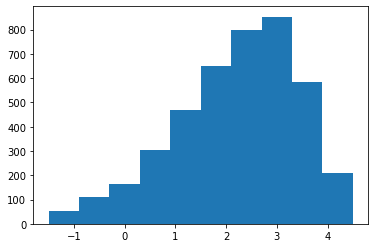

In [9]:
# construct target variable y (for the SARS-CoV-2 main protease data set, we convert Ki to pKi by taking negative decadic logarithm)

if settings_dict["dataset_name"] == "postera_sars_cov_2_mpro":
    y = -np.log10(dataframe.loc[:, settings_dict["prop_name"]].values.astype(float))
else:
    y = dataframe.loc[:, settings_dict["prop_name"]].values.astype(float)

print("Mean Value (Target) = ", np.mean(y))
print("Standard Deviation (Target) = ", np.std(y))
print("Maximum Value (Target) = ", np.amax(y))
print("Minimum Value (Target) = ", np.amin(y), "\n")

print("Shape of y = ", y.shape)
print("\n y = ", y)

plt.hist(y)

Shape of x_smiles =  (4200,)
Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21


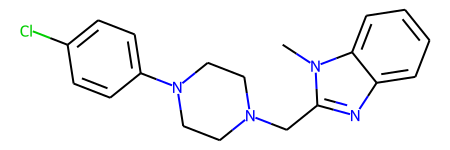

In [10]:
# extract SMILES strings

x_smiles = np.reshape(dataframe["SMILES"].values, (len(dataframe), 1))[:,0]

print("Shape of x_smiles = ", x_smiles.shape)
print(x_smiles[0])
display(Chem.MolFromSmiles(x_smiles[0]))

In [11]:
# create dictionary that maps smiles strings to their target values

x_smiles_to_y_dict = dict(list(zip(x_smiles, y)))

# Prepare Data Split

In [44]:
# choose settings for dictionary that contains indices for data splits

settings_dict["split_type"] = "rand" # choose "rand" for random split and "scaff" for scaffold split
settings_dict["split_type_rand_stratified"] = False # given a random split and a classification problem, choose whether to stratify the split
settings_dict["k_splits"] = 2 # choose number of cross validation folds k_splits
settings_dict["m_reps"] = 3 # choose number of random seeds m_reps with which the cross validation scheme is repeated
settings_dict["random_state_cv"] = 42 # choose random state

In [45]:
# construct dictionary that contains indices for data splits

if settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == False:
    
    data_split_dict = create_data_split_dict_random(x_smiles = x_smiles,
                                                    k_splits = settings_dict["k_splits"],
                                                    m_reps = settings_dict["m_reps"],
                                                    random_state_cv = settings_dict["random_state_cv"])

elif settings_dict["split_type"] == "rand" and settings_dict["split_type_rand_stratified"] == True:
    
    data_split_dict = create_data_split_dict_random_strat(x_smiles = x_smiles,
                                                          y = y,
                                                          k_splits = settings_dict["k_splits"],
                                                          m_reps = settings_dict["m_reps"],
                                                          random_state_cv = settings_dict["random_state_cv"])
    
elif settings_dict["split_type"] == "scaff":
    
    data_split_dict = create_data_split_dict_scaffold(x_smiles = x_smiles,
                                                      k_splits = settings_dict["k_splits"],
                                                      m_reps = settings_dict["m_reps"],
                                                      scaffold_func = "Bemis_Murcko_generic",
                                                      random_state_cv = settings_dict["random_state_cv"])

# Evaluate Models

In [56]:
# choose ECFP hyperparameters

settings_dict["ecfp_settings"] = {"mol_to_invs_function": ecfp_invariants, # ecfp_invariants or fcfp_invariants
                                  "radius": 2, # 0 or 1 or 2 or 3 ...
                                  "pool_method": "sort_and_slice", # "hashed" or "sort_and_slice" or "filtered" or "mim"
                                  "dimension": 1024, # 256 or 512 or 1024 or 2048 or 4096 ...
                                  "use_bond_invs": True, # True or False
                                  "use_chirality": True, # True or False
                                  "use_counts": False} # True or False

In [40]:
# chose ml model: random forest or multilayer perceptron

settings_dict["ml_model"] = "rf" # "rf" or "mlp"

In [41]:
# choose rf hyperparameters

settings_dict["rf_settings"] = {"n_estimators" : 100,
                                "max_depth" : None,
                                "min_samples_leaf" : 1,
                                "min_samples_split" : 2,
                                "bootstrap" : True,
                                "max_features": "sqrt",
                                "random_state" : 42}

if settings_dict["task_type"] == "regression":

    settings_dict["rf_settings"]["criterion"] = "squared_error"

elif settings_dict["task_type"] == "classification":

    settings_dict["rf_settings"]["criterion"] = "gini"

In [42]:
# choose mlp hyperparameters

settings_dict["mlp_settings"] = {"architecture" : list(arch(settings_dict["ecfp_settings"]["dimension"], 1, 512, 5)),
                                "hidden_activation" : nn.ReLU(),
                                "use_bias" : True,
                                "hidden_dropout_rate" : 0.25,
                                "hidden_batchnorm" : True,
                                "batch_size" : 64,
                                "dataloader_shuffle" : True,
                                "dataloader_drop_last" : True,
                                "learning_rate" : 1e-3,
                                "lr_lambda" : lambda epoch: max(0.98**epoch, 1e-2),
                                "lr_last_epoch": 0,
                                "weight_decay" : 0.1,
                                "num_epochs" : 250,
                                "optimiser" : torch.optim.AdamW,
                                "print_results_per_epochs" : None}

if settings_dict["task_type"] == "regression":

    settings_dict["mlp_settings"]["output_activation"] = nn.Identity()
    settings_dict["mlp_settings"]["loss_function"] = nn.MSELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "regression"

elif settings_dict["task_type"] == "classification":

    settings_dict["mlp_settings"]["output_activation"] = nn.Sigmoid()
    settings_dict["mlp_settings"]["loss_function"] = nn.BCELoss()
    settings_dict["mlp_settings"]["performance_metrics"] = "classification"

In [57]:
%%time
# run model and save results

# dictionary to save results over the k_splits-fold cross validation with m_reps random seeds
scores_dict = {}

# ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
    
    # create ecfp featuriser
    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                        x_smiles_train = x_smiles[ind_train], 
                                        y_train = y[ind_train], 
                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,
                                        base = 2, 
                                        random_state = 42)
    
    # create ecfp-based feature matrices
    X_train = featuriser(x_smiles[ind_train])
    X_test = featuriser(x_smiles[ind_test])

    # create ml model + train ml model + make predictions on test set
    if settings_dict["ml_model"] == "rf":
        
        rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
        rf_model.fit(X_train, y[ind_train])
        y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])
        
    if settings_dict["ml_model"] == "mlp":
        
        mlp_model = create_mlp_model(settings_dict["mlp_settings"])
        (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
        plt.plot(loss_curve_train)
        plt.plot(loss_curve_test)
        y_test_pred = make_mlp_prediction(mlp_model, X_test)
        
    # record scores
    print(m, k)
    if settings_dict["task_type"] == "regression":
        scores_dict[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = True)
    elif settings_dict["task_type"] == "classification":
        scores_dict[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = True)
        
# summarise, display and save scores for this experiment
summarise_display_and_save_results_and_settings(scores_dict, settings_dict, display_results = True)

Number of unique circular substructures with specified parameters in molecular training data set =  11562
0 0


MAE    MedAE      RMSE   MaxAE       MSE  PearsonCorr   R2Coeff  \
Scores:  0.662294  0.53036  0.860095  3.2206  0.739764      0.70403  0.486495   

         Test Cases  
Scores:      2100.0

Number of unique circular substructures with specified parameters in molecular training data set =  11685
0 1


MAE     MedAE      RMSE   MaxAE       MSE  PearsonCorr  \
Scores:  0.676304  0.531758  0.877097  3.4915  0.769299     0.698275   

          R2Coeff  Test Cases  
Scores:  0.470589      2100.0

Number of unique circular substructures with specified parameters in molecular training data set =  11811
1 0


MAE   MedAE      RMSE   MaxAE       MSE  PearsonCorr   R2Coeff  \
Scores:  0.657243  0.5411  0.844173  3.2917  0.712628     0.706672  0.487921   

         Test Cases  
Scores:      2100.0

Number of unique circular substructures with specified parameters in molecular training data set =  11563
1 1


MAE   MedAE     RMSE  MaxAE      MSE  PearsonCorr   R2Coeff  \
Scores:  0.667691  0.5232  0.86428  3.276  0.74698     0.722525  0.502459   

         Test Cases  
Scores:      2100.0

Number of unique circular substructures with specified parameters in molecular training data set =  11834
2 0


MAE     MedAE      RMSE    MaxAE       MSE  PearsonCorr  \
Scores:  0.67139  0.525667  0.873236  3.47805  0.762542     0.699449   

          R2Coeff  Test Cases  
Scores:  0.475776      2100.0

Number of unique circular substructures with specified parameters in molecular training data set =  11537
2 1


MAE    MedAE      RMSE   MaxAE      MSE  PearsonCorr   R2Coeff  \
Scores:  0.670294  0.52935  0.866193  3.1793  0.75029     0.699429  0.478649   

         Test Cases  
Scores:      2100.0

MAE     MedAE      RMSE     MaxAE       MSE  PearsonCorr  \
(0, 0)  0.662294  0.530360  0.860095  3.220600  0.739764     0.704030   
(0, 1)  0.676304  0.531758  0.877097  3.491500  0.769299     0.698275   
(1, 0)  0.657243  0.541100  0.844173  3.291700  0.712628     0.706672   
(1, 1)  0.667691  0.523200  0.864280  3.276000  0.746980     0.722525   
(2, 0)  0.671390  0.525667  0.873236  3.478050  0.762542     0.699449   
(2, 1)  0.670294  0.529350  0.866193  3.179300  0.750290     0.699429   
mean    0.667536  0.530239  0.864179  3.322858  0.746917     0.705063   
std     0.006229  0.005650  0.010566  0.120248  0.018181     0.008346   

         R2Coeff  Test Cases  
(0, 0)  0.486495      2100.0  
(0, 1)  0.470589      2100.0  
(1, 0)  0.487921      2100.0  
(1, 1)  0.502459      2100.0  
(2, 0)  0.475776      2100.0  
(2, 1)  0.478649      2100.0  
mean    0.483648      2100.0  
std     0.010310         0.0

CPU times: user 34.5 s, sys: 24 ms, total: 34.5 s
Wall time: 34.5 s


In [1]:
%%time
# run full battery of experiments for one data set and data splitting type with both rfs and mlps

# first clear folder from previous experimental results
delete_all_files_in_folder("results/" + settings_dict["dataset_name"] + "/" + settings_dict["split_type"] + "/")

for pool_method in ["hashed", "filtered", "mim", "sort_and_slice"]:
    for dimension in [512, 1024, 2048, 4096]:
        for inv_func in [ecfp_invariants, fcfp_invariants]:
            for radius in [1, 2, 3]:

                print("pool_method = ", pool_method)
                print("dimension = ", dimension)
                print("inv_func = ", inv_func)
                print("radius = ", radius, "\n")

                # choose ECFP hyperparameters
                settings_dict["ecfp_settings"] = {"mol_to_invs_function": inv_func,
                                                  "radius": radius,
                                                  "pool_method": pool_method,
                                                  "dimension": dimension,
                                                  "use_bond_invs": True,
                                                  "use_chirality": True,
                                                  "use_counts": False}

                # run rf- and mlp models and save results
                scores_dict_rf = {}
                scores_dict_mlp = {}

                # ind_train and ind_test contain the indices for the data split corresponding to the k-th fold with the m-th random seed
                for ((m, k), (ind_train, ind_test)) in data_split_dict.items():
                    
                    # create ecfp featuriser
                    featuriser = create_ecfp_featuriser(ecfp_settings = settings_dict["ecfp_settings"], 
                                                        x_smiles_train = x_smiles[ind_train], 
                                                        y_train = y[ind_train], 
                                                        discretise_y = True if settings_dict["task_type"] == "regression" else False,  
                                                        base = 2, 
                                                        random_state = 42)

                    # create ecfp-based feature matrices
                    X_train = featuriser(x_smiles[ind_train])
                    X_test = featuriser(x_smiles[ind_test])
                    
                    # create rf model + train ml model + make predictions on test set
                    rf_model = create_rf_model(settings_dict["rf_settings"], settings_dict["task_type"])
                    rf_model.fit(X_train, y[ind_train])
                    y_test_pred = make_rf_prediction(rf_model, X_test, settings_dict["task_type"])

                    # record rf scores
                    print(m, k, "rf")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_rf[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_rf[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False)
                    
                    # create mlp model + train ml model + make predictions on test set
                    settings_dict["mlp_settings"]["architecture"][0] = dimension
                    mlp_model = create_mlp_model(settings_dict["mlp_settings"])
                    (loss_curve_train, loss_curve_test) = train_mlp_model(mlp_model, settings_dict["mlp_settings"], X_train, y[ind_train], X_test, y[ind_test])
                    y_test_pred = make_mlp_prediction(mlp_model, X_test)

                    # record mlp scores
                    print(m, k, "mlp")
                    if settings_dict["task_type"] == "regression":
                        scores_dict_mlp[(m, k)] = regression_scores(y[ind_test], y_test_pred, display_results = False)
                    elif settings_dict["task_type"] == "classification":
                        scores_dict_mlp[(m, k)] = binary_classification_scores(y[ind_test], y_test_pred, display_results = False) 
                    
                # summarise, display and save scores for this experiment
                settings_dict["ml_model"] = "rf"
                summarise_display_and_save_results_and_settings(scores_dict_rf, settings_dict, display_results = True)
                settings_dict["ml_model"] = "mlp"
                summarise_display_and_save_results_and_settings(scores_dict_mlp, settings_dict, display_results = True)
                print("\n \n \n")

NameError: name 'a' is not defined

# Results Visualisations

Dataset names:

    "ames_mutagenicity",
    "aqsoldb_solubility",
    "lit_pcba_esr_ant",
    "moleculenet_lipophilicity",
    "postera_sars_cov_2_mpro".
    
Available classification metrics: 

    "PRC-AUC",
    "AUROC", 
    "Accuracy", 
    "Balanced Accuracy", 
    "F1-Score", 
    "MCC", 
    "Sensitivity", 
    "Specificity", 
    "Precision", 
    "Negative Predictive Value", 
    "Test Cases", 
    "Negative Test Cases", 
    "Positive Test Cases".

Available regression metrics:

    "MAE", 
    "MedAE", 
    "RMSE", 
    "MaxAE", 
    "MSE", 
    "PearsonCorr", 
    "R2Coeff", 
    "Test Cases".

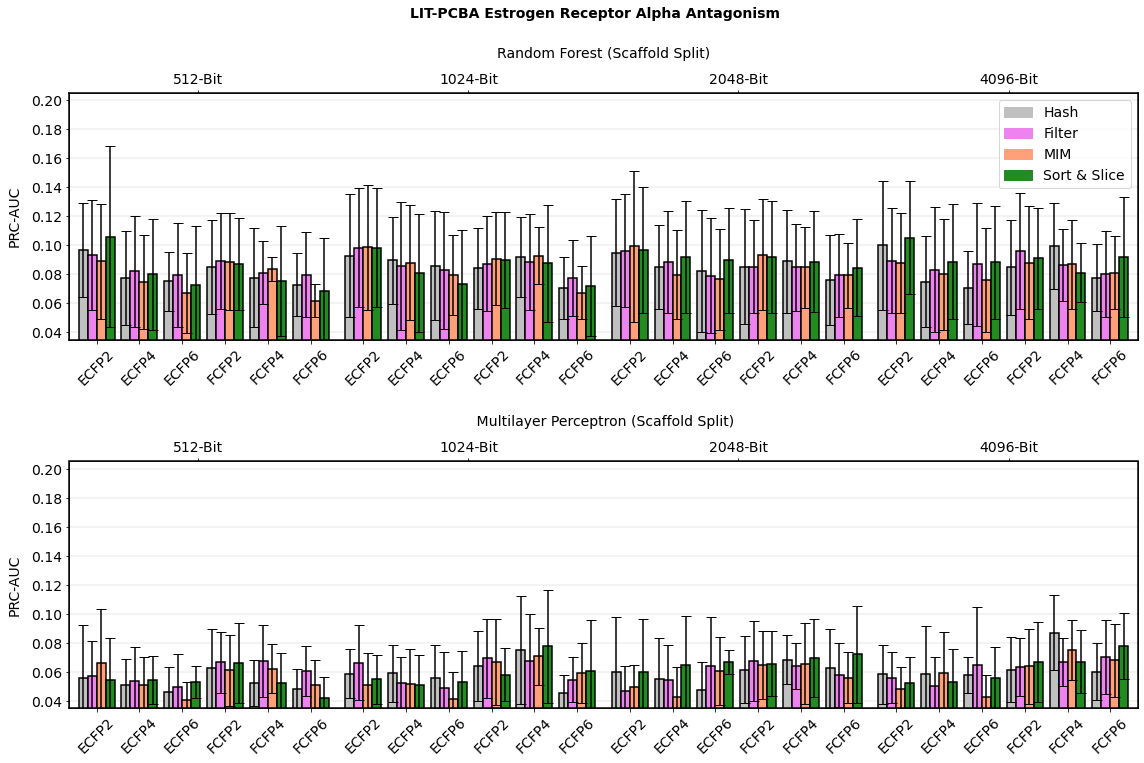

In [7]:
visualise_bar_charts(dataset_name = "lit_pcba_esr_ant", # specify dataset name
                     split_type = "scaff", # specify split type "rand" or "scaff" (for random or scaffold split)
                     metric = "PRC-AUC", # specify performance metric,
                     y_lims = (0.04, 0.2), # specify limits of y-axis (set to "None" for automatic limits)
                     y_unit = "") # specify unit for y-axis (if applicable)

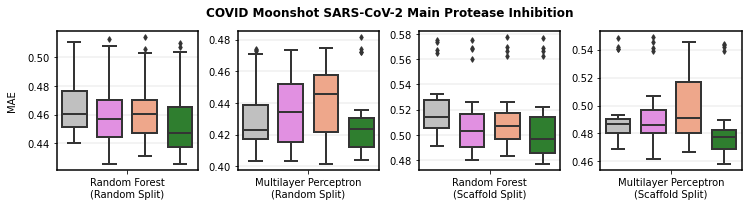

In [8]:
visualise_box_plots(dataset_name = "postera_sars_cov_2_mpro", # specify dataset name
                    metric = "MAE", # specify performance metric
                    y_unit = "", # specify unit for y-axis if applicable
                    show_legend = False, # show legend or not
                    show_x_ticks = True) # show text below subplots or not